## E1: Dice Coefficient

This experiment looks at the effectiveness of using the dice coefficient for ASAG.

$$
\frac{2\lvert X \cap Y \rvert}{\lvert X \rvert + \lvert Y \rvert}
$$

All these techniques are mathematical set techniques. This means multiple occurances of words are all combined into one word.

It is run on the English, German and Spanish Datasets.

In [1]:
import sys
sys.path.append('../')
sys.path.append('../../../')
import exp_libs.word_overlap as wo
import libs.preprocessing as pp
import libs.stats as stats
import libs.utils as utils
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Load Dataset
df_en = pd.read_csv("../../../datasets/final/en/asag_v2_en_filter.csv", sep='~')
print(len(df_en))
df_en.head(2)

2010


ID  AID  QID                                             Prompt  \
0  1.1    1    1   What is the role of a prototype program in pr...   
1  1.1    1    1   What is the role of a prototype program in pr...   

                                                  MA  \
0   To simulate the behaviour of portions of the ...   
1   To simulate the behaviour of portions of the ...   

                                                 MA2  \
0  to provide an example and feedback of how the ...   
1  to provide an example and feedback of how the ...   

                                                 MA3  \
0  to serve as a proof of concept and illustrate ...   
1  to serve as a proof of concept and illustrate ...   

                               NA  \
0  to find errors or collect data   
1  to find errors or collect data   

                                                  SA  MyScore  \
0   High risk problems are address in the prototy...        4   
1   To simulate portions of the desired final pro...        5   

           Feedback Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect            NaN    3.5             2             1  
1  correct_complete            NaN    5.0             2             1

In [3]:
pipeline_phases = { 'case_normalization' : pp.case_normalization,
                    'punctuation_removal' : pp.punctuation_removal,
                    'remove_stopwords' : pp.create_remove_stopwords(pp.EN_STOPS),
                    'stemming' : pp.create_stemmer(pp.EN_STEMMER)}

pipeline = pp.create_pipeline(pipeline_phases, pp.whitespace_tokenize)

In [4]:
reload(wo)
results = wo.execute_word_overlap_model(df_en, pipeline, wo.dice_coefficient)

             precision    recall  f1-score   support

        0.0       0.04      1.00      0.08        14
        1.0       0.01      0.50      0.01         8
        2.0       0.06      0.18      0.09       234
        3.0       0.01      0.02      0.02       157
        4.0       0.10      0.02      0.03       676
        5.0       1.00      0.02      0.04       921

avg / total       0.50      0.05      0.04      2010

Pearson's R: 0.39635010424312866
Cohen's Kappa: -0.02750153278396783
MAE: 2.5348258706467663
Accuracy: 4.68%
Precision: 50.06%
Recall: 4.68%
F1-Measure: 4.16%
Stored 'exp1_data' (dict)


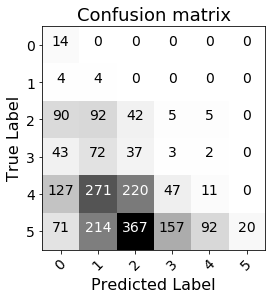

In [5]:
reload(stats)
stats.print_all_stats(results['y_true'], results['y_pred'])

exp1_data = stats.get_all_stats(results['y_true'], results['y_pred'])
%store exp1_data

stats.plot_confusion_matrix(stats.cm(results['y_true'], results['y_pred']), classes=np.arange(6))

             precision    recall  f1-score   support

          0       0.27      0.94      0.42       477
          1       0.92      0.20      0.33      1533

avg / total       0.76      0.38      0.35      2010

Pearson's R: 0.16233128953431106
Cohen's Kappa: 0.07708613186342961
MAE: 0.5925373134328358
Accuracy: 37.86%
Precision: 76.18%
Recall: 37.86%
F1-Measure: 35.38%
Stored 'exp1_data_pf' (dict)


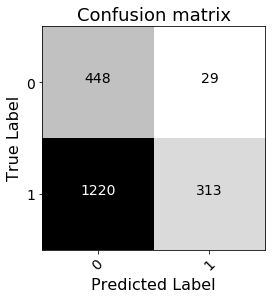

In [6]:
## Pass/Fail Evaluation
yt_pf = utils.convert_to_pass_fail(results['y_pred'])

stats.print_all_stats(df_en['Class2_Score'], yt_pf)

exp1_data_pf = stats.get_all_stats(df_en['Class2_Score'], yt_pf)
%store exp1_data_pf

stats.plot_confusion_matrix(stats.cm(df_en['Class2_Score'], yt_pf), classes=np.arange(2))

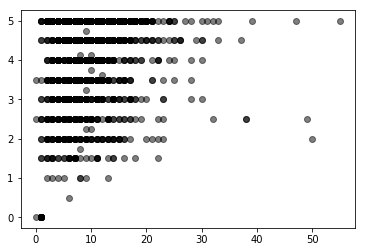

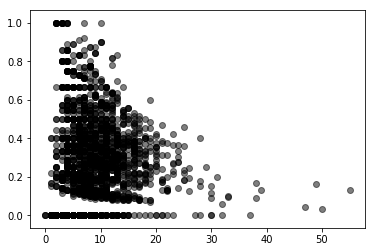

In [96]:
## Errors are introduced because in actual model longer answers tend to receive higher scores, but the process of 
## token word overlap demotes answers which are longer.
answer_lengths = list(map(lambda x: len(x), results['sets'][:,1]))
plt.scatter(answer_lengths, results['y_true_raw'], color='k', alpha=0.5)
plt.show()
plt.scatter(answer_lengths, results['y_pred_raw'], color='k', alpha=0.5)

### H1 Evaluation:

1. answers which have a lot of tokens in common with model answer have high/correct scores

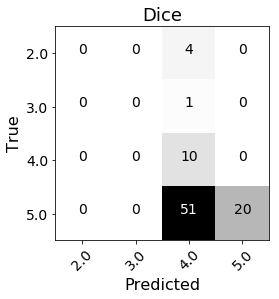

In [15]:
reload(wo)
reload(stats)
idxs = results['y_pred_raw'] > 0.75
klasses = np.unique(results['y_true'][idxs])
stats.plot_confusion_matrix(stats.cm(results['y_true'][idxs], results['y_pred'][idxs]), classes=klasses, title='Dice', savefile='../renderings/dice')

## Result:

Hypothesis is confirmed. Of 71 answers labeled 5.0 when tokens overlapped the model correctly predicted 20 as 5.0 and the other 51 received a score of 4.0.
10 Items with a label of 4.0 were all correctly identified and a few other high overlap items were misclassified.

In [63]:
reload(wo)
# inspecting false friends i.e. high overlap items which have low scores
idxs2 = np.logical_and(results['y_pred_raw'] > 0.75, results['y_true'] == 2.0)

wo.inspect_results(df_en, results['y_true'], results['y_pred'], idxs2, results['sets'], size=2)

Prompt:  Order the following functions by their running time: n to the power of 2; log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n!; n to the power of 3. 
Score: 2.0, Score-Pred: 4
MA:  log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n to the power of 2; n to the power of 3; n! 
MA_set: {'log', 'n!', '2', '-lrb-', 'n', '-rrb-', ';', '2;', '3;', 'power'}
SA:  2 to the power of -LRB- log n -RRB- , n to the power of 3, n to the power of 2, log -LRB- log n -RRB- , n! 
SA_set: {'log', 'n!', '2', '3', '-lrb-', 'n', '-rrb-', 'power'}
Prompt:  Order the following functions by their running time: n to the power of 2; log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n!; n to the power of 3. 
Score: 2.0, Score-Pred: 4
MA:  log -LRB- log n -RRB- ; 2 to the power of -LRB- log n -RRB- ; n to the power of 2; n to the power of 3; n! 
MA_set: {'log', 'n!', '2', '-lrb-', 'n', '-rrb-', ';', '2;', '3;', 'power'}
SA:  2 to the power of -LRB- log n -RRB- , n to the

#### Reasoning for False Prediction

1. Where ordering matters! Questions which require the student to put a response in a particular order completely fail.

## H2 : Evaluation

1. Do correct answers with different wordings have lower scores?

Short Answer: Yes, the model misses a lot of answers which are correct and use different wordings.

145


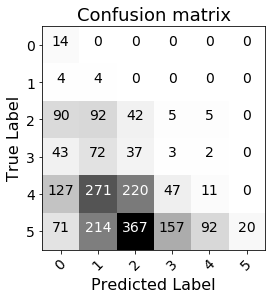

Prompt:  Which implementation -LRB- array-based vs. list-based -RRB- is preferred, and why? 
Score: 5.0, Score-Pred: 0
MA:  Link-based, because they are dynamic -LRB- no size constraints -RRB- 
MA_set: {'link-bas', '-lrb-', '-rrb-', 'dynam', 'constraint', 'size'}
SA:  Array-based prevents the push operation from adding an item to the stack if the stack 's size limit, which is the size of the array, has been reached.  List-base much simpler to write and does not have a fixed size. 
SA_set: {'array-bas', 'fix', 'push', 'oper', 'write', 'limit', 'item', 'array', 'reach', 'much', "'s", 'simpler', 'stack', 'ad', 'list-bas', 'size', 'prevent'}
Prompt:  What is the base case for a recursive implementation of merge sort? 
Score: 5.0, Score-Pred: 0
MA:  When the size of the array to be sorted is 1 -LRB- or 2 -RRB- 
MA_set: {'2', '-lrb-', 'array', '-rrb-', '1', 'sort', 'size'}
SA:  The sequence of numbers has zero or one elements. 
SA_set: {'zero', 'number', 'element', 'sequenc', 'one'}
Prompt: 

In [74]:
idxs3 = np.logical_and(results['y_pred_raw'] < 0.2, results['y_true'] > 4.0)
print(len(df_en[idxs3]))
cm3 = stats.cm(results['y_true'], results['y_pred'])
stats.plot_confusion_matrix(cm3, classes=np.arange(6))

wo.inspect_results(df_en, results['y_true'], results['y_pred'], idxs3, results['sets'], size=10)

## How much of difference does stopword Removal Make?

             precision    recall  f1-score   support

        0.0       0.07      0.93      0.14        14
        1.0       0.01      0.50      0.01         8
        2.0       0.07      0.22      0.10       234
        3.0       0.01      0.02      0.01       157
        4.0       0.06      0.01      0.02       676
        5.0       0.79      0.01      0.02       921

avg / total       0.39      0.04      0.03      2010

Pearson's R: 0.4083893636359681
Cohen's Kappa: -0.03733866849066425
MAE: 2.3601990049751245
Accuracy: 4.43%
Precision: 39.02%
Recall: 4.43%
F1-Measure: 3.07%


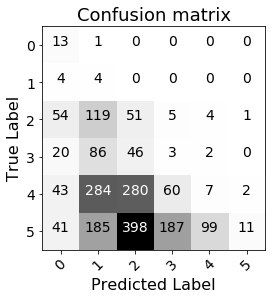

In [78]:
pipeline_phases1 = { 'case_normalization' : pp.case_normalization,
                     'punctuation_removal' : pp.punctuation_removal,
                     'stemming' : pp.create_stemmer(pp.EN_STEMMER)}

pipeline1 = pp.create_pipeline(pipeline_phases1, pp.whitespace_tokenize)

results1 = wo.execute_word_overlap_model(df_en, pipeline1, wo.dice_coefficient)

stats.print_all_stats(results1['y_true'], results1['y_pred'])
stats.plot_confusion_matrix(stats.cm(results1['y_true'], results1['y_pred']), classes=np.arange(6))

### Results

Removing Stopwords adds very little improvement - less than $0.5\%$ on recall and $1\%$ for precision. This is due to the fact that in this approach any stopword can only make up at maximum one word in the sentence set of tokens.

## How good is this method for Fill-In-The-Blank Style Questions?

Hypothesis: it should be quite good for short model answers and short student responses, at least compared to longer answers, since FITB type questions usually are all or nothing affairs.

432
             precision    recall  f1-score   support

        0.0       0.11      1.00      0.20        13
        1.0       0.01      0.07      0.02        15
        2.0       0.02      0.06      0.03        33
        3.0       0.00      0.00      0.00         8
        4.0       0.00      0.00      0.00        45
        5.0       1.00      0.39      0.56       318

avg / total       0.74      0.32      0.42       432

Pearson's R: 0.4792068440292584
Cohen's Kappa: 0.10578027306367233
MAE: 2.037037037037037
Accuracy: 32.41%
Precision: 74.18%
Recall: 32.41%
F1-Measure: 42.26%


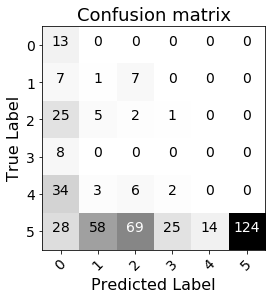

In [80]:
## Load Dataset
df_fitb = pd.read_csv("../../../datasets/final/en/asag_v2_en_fitb.csv", sep='~')
print(len(df_fitb))
df_fitb.head(1)

results_fitb = wo.execute_word_overlap_model(df_fitb, pipeline, wo.dice_coefficient)

stats.print_all_stats(results_fitb['y_true'], results_fitb['y_pred'])
stats.plot_confusion_matrix(stats.cm(results_fitb['y_true'], results_fitb['y_pred']), classes=np.arange(6))

### Results

It is vastly better at FITB style questions, reaffirming the notion that those questions are fundamentally different than the rest; that is they are in their own category. Whether or not using FITB methods for dealing with such questions is the best approach remains to be seen.

## German Evaluation

In [75]:
## Load Dataset
df_de = pd.read_csv("../../../datasets/final/de/asag_v2_de_filter.csv", sep='~')
print(len(df_de))
df_de.head(1)

2010


ID  AID  QID                                             Prompt  \
0  1.1    1    1  Welche Rolle spielt ein Prototyp-Programm bei ...   

                                                  MA  \
0  Um das Verhalten von Teilen des gewünschten So...   

                                                 MA2  \
0  um ein Beispiel und Feedback zur Funktionsweis...   

                                                 MA3  \
0  als Konzeptnachweis dienen und veranschauliche...   

                                          NA  \
0  um Fehler zu finden oder Daten zu sammeln   

                                                  SA  MyScore  \
0  In dem Prototyp-Programm werden Probleme mit h...        4   

           Feedback Feedback_Notes  Score  Class3_Score  Class2_Score  
0  correct_indirect            NaN    3.5             2             1

             precision    recall  f1-score   support

        0.0       0.02      1.00      0.04        14
        1.0       0.00      0.12      0.00         8
        2.0       0.05      0.09      0.06       234
        3.0       0.01      0.01      0.01       157
        4.0       0.10      0.01      0.01       676
        5.0       1.00      0.01      0.02       921

avg / total       0.50      0.03      0.02      2010

Pearson's R: 0.3354477025579504
Cohen's Kappa: -0.01934682525053999
MAE: 3.0144278606965176
Accuracy: 2.54%
Precision: 49.77%
Recall: 2.54%
F1-Measure: 2.17%


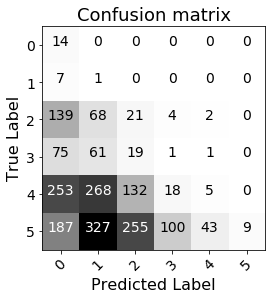

In [76]:
pipeline_phases2 = { 'case_normalization' : pp.case_normalization,
                    'punctuation_removal' : pp.punctuation_removal,
                    'remove_stopwords' : pp.create_remove_stopwords(pp.DE_STOPS),
                    'stemming' : pp.create_stemmer(pp.DE_STEMMER)}

pipeline2 = pp.create_pipeline(pipeline_phases2, pp.whitespace_tokenize)

results2 = wo.execute_word_overlap_model(df_de, pipeline2, wo.dice_coefficient)

stats.print_all_stats(results2['y_true'], results2['y_pred'])
stats.plot_confusion_matrix(stats.cm(results2['y_true'], results2['y_pred']), classes=np.arange(6))

## Spanish Evaluation

2010
             precision    recall  f1-score   support

        0.0       0.05      1.00      0.09        14
        1.0       0.00      0.38      0.01         8
        2.0       0.05      0.13      0.07       234
        3.0       0.01      0.02      0.02       157
        4.0       0.06      0.01      0.02       676
        5.0       0.95      0.02      0.04       921

avg / total       0.46      0.04      0.03      2010

Pearson's R: 0.4294537204947332
Cohen's Kappa: -0.03052615960192262
MAE: 2.569154228855721
Accuracy: 3.73%
Precision: 46.42%
Recall: 3.73%
F1-Measure: 3.40%


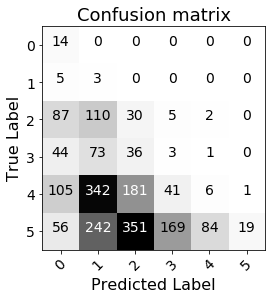

In [77]:
## Load Dataset
df_es = pd.read_csv("../../../datasets/final/es/asag_v2_es_filter.csv", sep='~')
print(len(df_es))
df_es.head(1)

pipeline_phases3 = { 'case_normalization' : pp.case_normalization,
                    'punctuation_removal' : pp.punctuation_removal,
                    'remove_stopwords' : pp.create_remove_stopwords(pp.ES_STOPS),
                    'stemming' : pp.create_stemmer(pp.ES_STEMMER)}

pipeline3 = pp.create_pipeline(pipeline_phases3, pp.whitespace_tokenize)

results3 = wo.execute_word_overlap_model(df_es, pipeline3, wo.dice_coefficient)

stats.print_all_stats(results3['y_true'], results3['y_pred'])
stats.plot_confusion_matrix(stats.cm(results3['y_true'], results3['y_pred']), classes=np.arange(6))